In [64]:
from lib.models import ResNet
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader,TensorDataset
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms,test_evaluation
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import plotly.express as px
import pandas as pd
from lib.utils import get_bout_statistics_for_predictions
import numpy as np
device = 'cuda'

class Gandalf(nn.Module):
    def __init__(self,n_input_size,n_hidden_state) -> None:
        super().__init__()
        self.n_hidden_state = n_hidden_state
        self.lstm = nn.LSTM(input_size=n_input_size,hidden_size=n_hidden_state,num_layers=5,batch_first=True,bidirectional=True)
        self.fc1 = nn.Linear(2*n_hidden_state*9,3)
    def forward(self,x):
        x = x.view(-1,9,5000)
        x,_ = self.lstm(x)
        x = self.fc1(x.reshape(-1,2*self.n_hidden_state*9))
        return x
        
model = Gandalf(5000,16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'w9_centered_tiny'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=32,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=32,shuffle=False)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)

Params:  668771


In [65]:
lossi = []

100%|██████████| 405/405 [00:03<00:00, 113.80it/s]


tensor(0.6424)


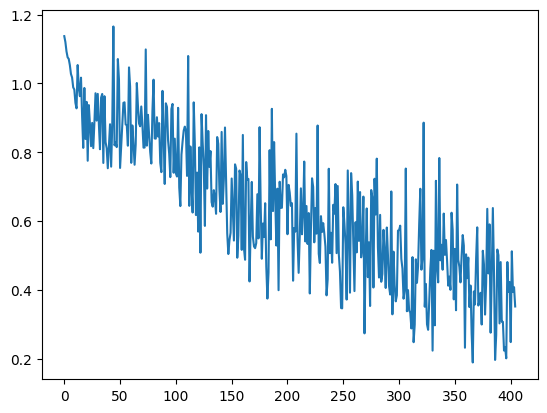

In [66]:

model.train()

for i in range(1):
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)
print(torch.tensor(lossi).mean())

In [67]:
loss_tr = []
loss_dev = []

In [70]:
pbar = tqdm(range(5))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


[0.3059376462046149,
 0.3062206096763681,
 0.266123576961421,
 0.25882132082553627,
 0.2486035519834663,
 0.23953939104461905,
 0.24381214658055325,
 0.2450946068271921,
 0.26109454789304454,
 0.257003303887919]

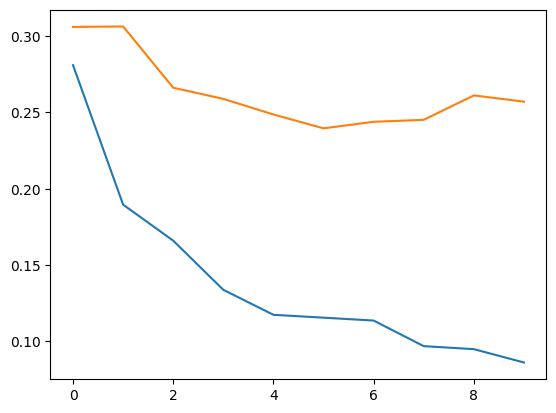

In [71]:
plt.plot(loss_tr)
plt.plot(loss_dev)
loss_dev